# $\mathrm{DANTE}$ for spin field reconstruction on the sphere

**Please cite the paper below if you make use of the code:**  
"*Wiener filtering and pure E/B decomposition of CMB maps with anisotropic correlated noise*,"  
Doogesh Kodi Ramanah, Guilhem Lavaux, Benjamin D. Wandelt [arXiv link](https://arxiv.org/abs/1906.10704)

<img src="Dante_cover.png" alt="Drawing" style="width: 1250px;"/>

### $\mathrm{DANTE}$ (DuAl messeNger filTEr) is designed to perform Wiener filtering and pure E/B decomposition on the sphere. The current version has the following (optional) features:

* Any arbitrary masks for I/Q/U (in `.fits` format)
* Inclusion of a beam
* Jacobi relaxation scheme to correct for non-orthogonality of spherical harmonic transforms
* A modified convergence scheme for speed-ups
* Generation of constrained realizations

### and allows for two possible noise models:

* Gaussian white noise (with I/Q/U correlations) - *Noise model A*
* Anisotropic correlated noise (spatial correlations + 1/f noise behaviour typical of Planck-like missions) - *Noise model B*

*Note:* Pure E/B decomposition can currently be done only with noise model B, but the same principles apply for the noise model A. This functionality will be added in a future release.

# $\mathrm{DANTE}$ dependencies

$\mathrm{DANTE}$ relies on the following standard `Python` packages and is compatible with both `Python2` and `Python3`:

* `healpy`: for spherical harmonic transforms (SHTs)
* `numba`: for generating efficient parallelized machine/native code for array manipulations on the sphere
* `astropy`: for handling `.fits` data files
* `tqdm`: for progress bar visualization

# Code organization

The key modules are as follows:

* `wiener.py`: Initialization phase. Contains the `WienerFilter` class, which loads the relevant data files (maps, mask, beam etc.) using the `Observations` class
* `dual_messenger.py`: Core of the $\mathrm{DANTE}$ package. Contains the `DualMessenger` class, which performs the reconstructions using `run_classic_filter` or `run_anisotropic_filter` (depending on choice of noise model)
* `dual_messenger_tools.py`: Library of useful and generic tools for array manipulations and algebraic computations etc.
* `observations.py`: Responsible for loading the data files, employed in the `WienerFilter` class
* `mock.py`: Provides several tools for mock validation purposes

# Generate some mock data

### Gaussian white noise (with I/Q/U correlations) - Noise model A

Need to specify the desired `healpy` parameters `nside` and `lmax`, whether or not to include beam (must specify name/path), type of noise model (set to white noise case by default) and the noise amplitude in muK per pixel. 

**Important**: For the signal covariance, a `.dat` file from CAMB is loaded in `mock.py`. For now, this must be manually set. The same file loaded in `dual_messenger.py`.

**Outputs**: `noise_covariance.npz`, `mock_map.fits`, `true_map.fits`, `true_map_alm_T.fits`, `true_map_alm_E.fits`, `true_map_alm_B.fits`, `mask_T_P.fits` (optional), `beam_T_P.npz` (optional), `true_beamed_map.fits` (optional)

### Without mask/beam

In [1]:
from mock import *

mock_gen(nside=128, lmax=128, masked=False, beamed=False, anisotropic_noise=False, noise_amplitude=100)

### Generating mock CMB data ###
### True polarized CMB map generated successfully ###
### Generating white noise ###
### Generating mock noise covariance ###
### Noise amplitude per pixel = 100.0 muK ###
### Mock polarized CMB map generated successfully ###
### Mock data saved successfully ###


### With mask/beam

In [1]:
from mock import *

mock_gen(nside=128, lmax=128, masked=True, beamed=True, anisotropic_noise=False, noise_amplitude=100, maskname="./COM_CMB_IQU-smica_1024_R2.02_full.fits", beamname="./COM_CMB_IQU-smica_1024_R2.02_full.fits")

### Generating mock CMB data ###
### True polarized CMB map generated successfully ###
### Beam saved successfully ###
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
### True beamed polarized CMB map generated successfully ###
### Generating white noise ###
### Generating mock noise covariance ###
### Noise amplitude per pixel = 100.0 muK ###
### Mock beamed polarized CMB map generated successfully ###
### Mock data saved successfully ###
### Upgrading/degrading mask to match choice of nside ###
### Mask saved successfully ###


# Running $\mathrm{DANTE}$ (for noise model A)

### Import relevant modules and set relevant `healpy` parameters (`nside` and `lmax`)

*Note:* `nside` will actually be inferred from the map size during execution, so it is not really required to specify this here, but it's more for convenience.

In [1]:
import observations
import wiener
import dual_messenger
import healpy as hp

nside = 128
lmax = 128

### The two required data files are the `map_name` and `noise_name` and this is handled by the `Observations` class in the `observations.py` module

In [2]:
data = observations.Observations(map_name="mock_map.fits", noise_name="noise_covariance.npz")

### To include a mask/beam in the analysis, simply load them as follows:

In [ ]:
data = observations.Observations(map_name="mock_map.fits", noise_name="noise_covariance.npz", mask_name="mask_T_P.fits", beam_name="beam_T_P.fits")

**Note:** When performing a mock validation, please ensure consistency between the above inputs and the ones employed in the mock generation. As mentioned above, the signal covariance is simply built from a `CAMB` output file and is currently anchored in both `dual_messenger.py` and `mock.py`. This may be changed to any signal covariance desired, as long as you build an array of shape $[\ell_{\mathrm{max}}+1,3,3]$ for the T/E/B components.

### Inputs prior to execution

We need to specify a few quantities as inputs:

* `convergence`: The convergence criterion (usually Cauchy norm, i.e. fractional difference computed from the solutions between successive iterations or $\chi^2$ - not yet added);

* `precision`: Desired precision of final solution;

* `cooling_step`: Using a larger step may result in faster convergence to the final solution, but the reconstruction on larger scales may suffer as a consequence. Generally, we do not lose much by using a larger step, but this is a bit ad hoc;

* `l_start`: Initial truncation for the cooling scheme;

* `relaxed_convergence_threshold`: Default is false. To accelerate the execution, we can relax the tolerance for initial steps in the cooling scheme (but not lower than $10^{-4}$). For instance, if desired precision is $10^{-6}$, the code forecasts the number of steps in the cooling scheme required for final convergence, and will automatically adjust the precision, i.e. increase from $10^{-4}$ for initial step to $10^{-6}$ for final step of cooling scheme;

* `store_steps`: Default is false. Activate to save the solution at each step in a long list (output of code);

* `jacobi_correction`: Default is false. It is well-known that SHTs are not orthogonal on the sphere (under the $\mathrm{HEALPix}$ scheme), so this is an option to correct for that, at the expense of a larger number of SHTs and hence, longer computation time;

* `constrained_realizations`: Default is false. To generate full-sky observations, this option can be activated;

* `compute_chi2`: Default is false. Activate to obtain the variation of $\chi^2$ as a function of iterations (output of code);

* `compute_residual`: Default is false. Activate to obtain the variation of the residual error given by $|Ax - y|/|y|$ as a function of iterations (output of code) - Not yet added for noise model A but available for B.

### Outputs

The code provides the following as output:

* `alm_wf`: Wiener-filtered map (T/E/B components) - Harmonic space representation;

* `s_wf`: Wiener-filtered map (T/E/B components) - Pixel space representation;

* `d_pixel`: This is simply the data used in the analysis, for convenience;

* `full_steps`: List that contains the solutions for all iterations, empty if not opted for;

* `residual_error_cauchy`: List that contains the residual errors, as given by the Cauchy criterion, for all iterations;

* `residual_error_pcg`: List that contains the residual errors, as given by $|Ax - y|/|y|$ (usually used in PCG algorithms), for all iterations, empty if not opted for;

* `epsilon_list`: If not opted for `relaxed_convergence_thresold`, this will simply be a constant corresponding to the desired final precision. Else, this will be a list with the precision employed at a given cooling step;

* `chi_squared`: List that contains the $\chi^2$ values for all iterations, empty if not opted for.

In [10]:
true_alms_T = hp.read_alm("true_map_alms_T.fits")
true_alms_E = hp.read_alm("true_map_alms_E.fits")
true_alms_B = hp.read_alm("true_map_alms_B.fits")

w = dual_messenger.DualMessenger(lmax, data)

alm_wf, s_wf, d_pixel, full_steps, residual_error_cauchy, residual_error_pcg, epsilon_list, chi_squared = w.run_classic_filter(convergence='norm', precision=10**-4, cooling_step=1.5, l_start=10, relaxed_convergence_threshold=False, store_steps=False, jacobi_correction=False, constrained_realizations=False, compute_chi2=False, compute_residual=False)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
### Activating / Deactivating            ###
*** No mask provided                     ***
*** No beam provided                     ***
*** White noise provided                 ***
*** Jacobi corrector deactivated         ***
*** Relaxed convergence deactivated      ***
*** Constrained realizations deactivated ***

    W E L C O M E ... 

     _______________________________________________________        _        _______________________________________________________                                                                
    |o|/\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///\/o/       / \       \o\/\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///\|o|
    |o|\///\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///\*\*\/o/       / _ \       \o\///\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///\*\*\/|o|
    |o|/\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///|o|      / (_) \      |o|\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///\*\*\///\|o|


/home/doogesh/Dante/dual_messenger.py:245: RuntimeWarning: divide by zero encountered in true_divide
  self.inv_S_diag = 1./Cov_S_diag


### Computation of Cov_T terminated     ###
### Computation of inv_N_bar terminated ###
### Precomputations over                ###
Execution time, in seconds,
33.71801018714905
v_trunk (mu) =
[6.87609495e+01 5.76449146e-04 2.77745351e-04]
Delta Norm = 0.264886


/home/doogesh/Dante/dual_messenger.py:256: RuntimeWarning: divide by zero encountered in true_divide
  inv_S_bar = 1./Cov_S_bar


Delta Norm = 0.111404
Delta Norm = 0.0697584
Delta Norm = 0.0499612
Delta Norm = 0.0375495
Delta Norm = 0.0289006
Delta Norm = 0.0225957
Delta Norm = 0.017877
Delta Norm = 0.0142772
Delta Norm = 0.011489
Delta Norm = 0.00930253
Delta Norm = 0.00757051
Delta Norm = 0.00618698
Delta Norm = 0.00507418
Delta Norm = 0.00417398
Delta Norm = 0.00344225
Delta Norm = 0.00284504
Delta Norm = 0.00235594
Delta Norm = 0.00195419
Delta Norm = 0.00162333
Delta Norm = 0.00135026
Delta Norm = 0.00112444
Delta Norm = 0.000937366
Delta Norm = 0.000782158
Delta Norm = 0.00065321
Delta Norm = 0.000545948
Delta Norm = 0.000456626
Delta Norm = 0.000382169
Delta Norm = 0.000320046
Delta Norm = 0.000268172
Delta Norm = 0.000224822
Delta Norm = 0.00018857
Delta Norm = 0.000158235
Delta Norm = 0.000132836
Delta Norm = 0.000111557
Delta Norm = 9.37221e-05
v_trunk (mu) =
[45.77994499  0.          0.        ]
Delta Norm = 0.000427675
Delta Norm = 0.000256228
Delta Norm = 0.000189605
Delta Norm = 0.000144783
Delta N

In [6]:
from pylab import *
from matplotlib import rc
rc('text', usetex=True)

### Visualize masks

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Temperature sky fraction is
0.7588450113932291
Polarization sky fraction is
0.8423258463541666


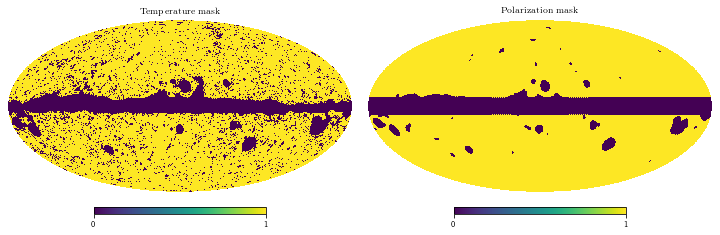

In [37]:
fig = plt.figure(figsize = (10,4))

mask_T_P = hp.read_map("mask_T_P.fits", field=(0,1,2))
mask = tuple(mask_T_P)

npix = mask_T_P[0].size
print("Temperature sky fraction is")
print(1. - ((npix - mask_T_P[0].sum())/npix))
print("Polarization sky fraction is")
print(1. - ((npix - mask_T_P[1].sum())/npix))
hp.mollview(mask[0], title=r'$\mathrm{Temperature \ mask}$', xsize=1200, sub=121)
hp.mollview(mask[1], title=r'$\mathrm{Polarization \ mask}$', xsize=1200, sub=122)

### Visualize reconstructed power spectra

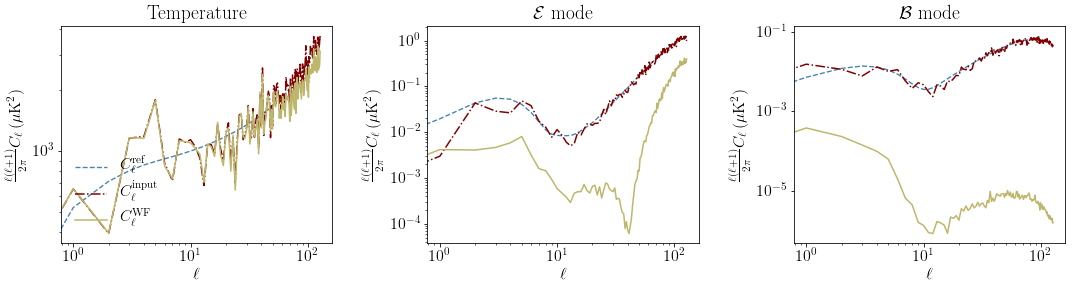

In [13]:
lmax_in = 128
nside_in = 128

fig=plt.figure(figsize = (18,4))

cls, _ = DKR_read_camb_cl("pol_data_boost_totCls.dat", lmax_in)
ell = np.arange(len(cls[0,1:]))
C_ell_WF = hp.alm2cl(alm_wf, lmax=lmax_in)
C_ell_WF_array = np.array(C_ell_WF)

#######################################
ax1 = fig.add_subplot(131)

C_ell_true_T = hp.alm2cl(true_alms_T, lmax=lmax_in)

loglog((cls[0,1:]*ell*(ell+1))/(2*np.pi), label=r'$C_{\ell}^{\mathrm{ref}}$', linestyle='--', linewidth=1.35, color = 'steelblue', alpha=1.0)
loglog((C_ell_true_T[1:]*ell*(ell+1))/(2*np.pi), label=r'$C_{\ell}^{\mathrm{input}}$', linestyle='-.', color = 'maroon', alpha=1.0)
loglog((C_ell_WF_array[0,1:]*ell*(ell+1))/(2*np.pi), label=r'$C_{\ell}^{\mathrm{WF}}$', linestyle='-', color = 'darkkhaki', alpha=1.0)

xlabel(r'$\ell$'); ylabel(r'$ \frac{\ell (\ell + 1)}{2 \pi} C_{\ell}\:(\mu \mathrm{K}^2)$');
title(r"$\mathrm{Temperature}$");
legend(loc=3).draw_frame(False);

#######################################
ax2 = fig.add_subplot(132)

C_ell_true_E = hp.alm2cl(true_alms_E, lmax=lmax_in)

loglog((cls[1,1:]*ell*(ell+1))/(2*np.pi), linestyle='--', linewidth=1.35, color = 'steelblue', alpha=1.0)
loglog((C_ell_true_E[1:]*ell*(ell+1))/(2*np.pi), linestyle='-.', color = 'maroon', alpha=1.0)

loglog((C_ell_WF_array[1,1:]*ell*(ell+1))/(2*np.pi), linestyle='-', color = 'darkkhaki', alpha=1.0)

xlabel(r'$\ell$'); ylabel(r'$ \frac{\ell (\ell + 1)}{2 \pi} C_{\ell}\:(\mu \mathrm{K}^2)$');
title(r"$\mathrm{\mathcal{E} \ mode}$");

#######################################
ax3 = fig.add_subplot(133)

C_ell_true_B = hp.alm2cl(true_alms_B, lmax=lmax_in)

loglog((cls[2,1:]*ell*(ell+1))/(2*np.pi), linestyle='--', linewidth=1.35, color = 'steelblue', alpha=1.0)
loglog((C_ell_true_B[1:]*ell*(ell+1))/(2*np.pi), linestyle='-.', color = 'maroon', alpha=1.0)

loglog((C_ell_WF_array[2,1:]*ell*(ell+1))/(2*np.pi), linestyle='-', color = 'darkkhaki', alpha=1.0)

xlabel(r'$\ell$'); ylabel(r'$ \frac{\ell (\ell + 1)}{2 \pi} C_{\ell}\:(\mu \mathrm{K}^2)$');
title(r"$\mathrm{\mathcal{B} \ mode}$");
#######################################

fig.subplots_adjust(wspace=0.35)    
matplotlib.rcParams.update({'font.size': 16});

### Simulated and Wiener-filtered maps

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


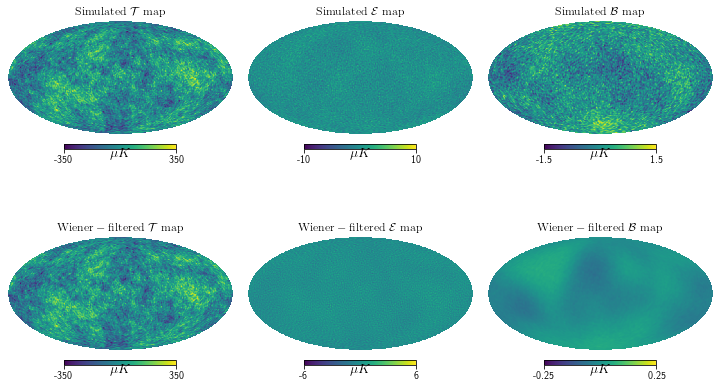

In [40]:
fig=plt.figure(figsize = (10,6))
clf();

simulated_map = hp.read_map("true_map.fits", field=(0,1,2))

simulated_E_map = hp.alm2map(true_alms_E, nside=nside_in, lmax=lmax_in)
simulated_B_map = hp.alm2map(true_alms_B, nside=nside_in, lmax=lmax_in)

WF_E_map = hp.alm2map(alm_wf[1,:], nside=nside_in, lmax=lmax_in)
WF_B_map = hp.alm2map(alm_wf[2,:], nside=nside_in, lmax=lmax_in)

hp.mollview(simulated_map[0,:], title = r'$\mathrm{Simulated \ \mathcal{T} \ map}$', min=-350, max=350, unit = r'$\mu K$', sub=231);
hp.mollview(s_wf[0,:], title = r'$\mathrm{Wiener-filtered \ \mathcal{T} \ map}$', min=-350, max=350, unit = r'$\mu K$', sub=234);

hp.mollview(simulated_E_map, title = r'$\mathrm{Simulated \ \mathcal{E} \ map}$', min=-10, max=10, unit = r'$\mu K$', sub=232);
hp.mollview(WF_E_map, title = r'$\mathrm{Wiener-filtered \ \mathcal{E} \ map}$', min=-6, max=6, unit = r'$\mu K$', sub=235);

hp.mollview(simulated_B_map, title = r'$\mathrm{Simulated \ \mathcal{B} \ map}$', min=-1.5, max=1.5, unit = r'$\mu K$', sub=233);
hp.mollview(WF_B_map, title = r'$\mathrm{Wiener-filtered \ \mathcal{B} \ map}$', min=-0.25, max=0.25, unit = r'$\mu K$', sub=236);

matplotlib.rcParams.update({'font.size': 8});